In [43]:
library(data.table)





ERROR: Error in parse(text = x, srcfile = src): <text>:3:8: unexpected symbol
2: #To ignore warning messages which clutters the output
3: import warnings
          ^


In [3]:
#loading the dataset.

data = fread('data_aarsregnskaper.csv')

In [4]:
#initial simple investigation of the data.
dim(data)
str(data)

[1] 1380494      75

Classes 'data.table' and 'data.frame':	1380494 obs. of  75 variables:
 $ Andre_avsetninger_for_forpliktelser                          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Andre_finansielle_instrumenter                               : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Andre_fordringer                                             : num  556686 9770612 -29964 44017568 156218 ...
 $ Andre_immaterielle_eiendeler                                 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Annen_driftsinntekt                                          : num  0.00 0.00 5.65e+08 4.32e+07 0.00 ...
 $ Annen_driftskostnad                                          : num  1.30e+07 2.16e+02 4.72e+08 3.42e+08 1.74e+06 ...
 $ Annen_finansinntekt                                          : num  20752918 0 0 31415028 0 ...
 $ Annen_finanskostnad                                          : num  2.04e+07 0.00 1.30e+08 3.24e+07 2.96e+04 ...
 $ Annen_innskutt_egenkapital                                   : num  2.70e+07 0.00 1.11

In [5]:
#Changing some variable data type to factor from character to be able to perform certain analysis.
data$fravalg_revisjon = as.factor(data$fravalg_revisjon) 
data$orgform = as.factor(data$orgform)
data$regler_smaa = as.factor(data$regler_smaa)
data$landkode = as.factor(data$landkode)
data$naeringskode = as.factor(data$naeringskode)

In [6]:
#Checking if theres too many or few accounts compared to organizations. Result: equal
install.packages('sqldf')
library(sqldf)
table_1c = sqldf("SELECT 
                 regnaar, 
                 count (orgnr) AS antall_regnskap, 
                 count (DISTINCT orgnr) AS antall_org
                 FROM data 
                 GROUP BY regnaar")

package 'sqldf' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\haava\AppData\Local\Temp\RtmpY9vnOY\downloaded_packages


Warning message:
"package 'sqldf' was built under R version 3.6.3"Loading required package: gsubfn
Warning message:
"package 'gsubfn' was built under R version 3.6.3"Loading required package: proto
Warning message:
"package 'proto' was built under R version 3.6.3"Loading required package: RSQLite
Warning message:
"package 'RSQLite' was built under R version 3.6.3"

In [7]:
#Checking the information on bankruptcies. 
summary(data$konkurs)

   Mode   FALSE    TRUE 
logical 1356002   24492 

In [8]:
#Grouping bankruptices by organizational form
table_1d = sqldf('SELECT
                 orgform,
                 SUM(CASE WHEN konkurs = 1 THEN 1 ELSE 0 END) AS konk,
                 SUM(CASE WHEN konkurs = 0 THEN 1 ELSE 0 END) AS ikke_konk
                 FROM data
                 GROUP BY orgform')

In [9]:

#Loading plot library
library(ggplot2)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


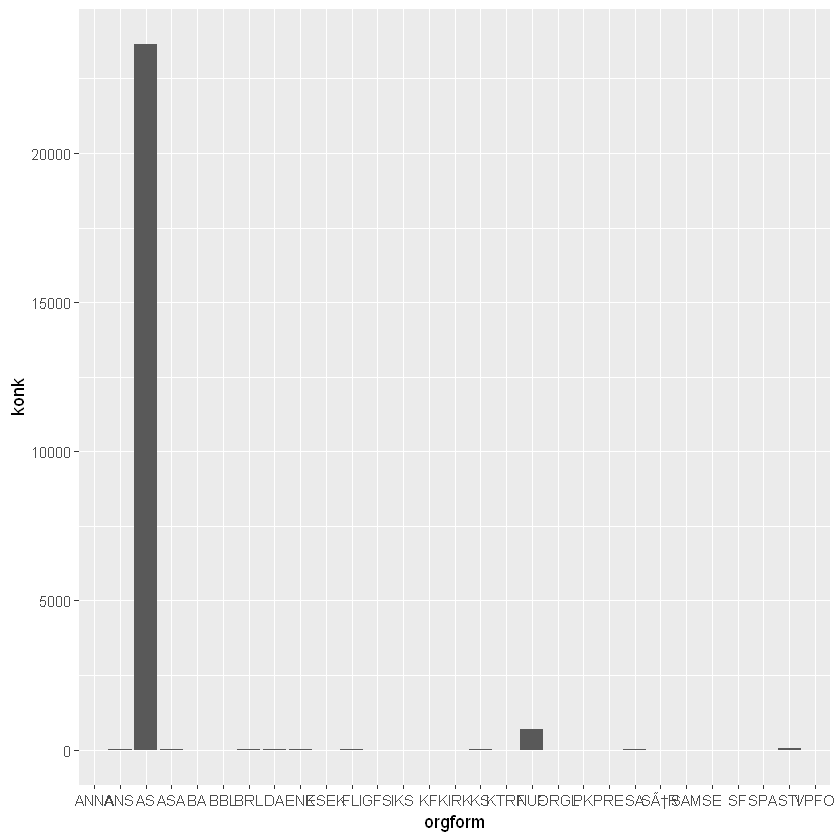

In [10]:
#Plotting bankruptices based on organizational form
plot_1e = 
  ggplot(table_1d, aes(x=orgform))+
  geom_col(aes(y = konk))
plot_1e

In [11]:
#The plot above is not very informative because of the vast amount of AS compared to other organizational forms
#therefore transforming to relative share of bankruptcies to number of organizations within respective form
table_1d$andel_konkurs = table_1d$konk/(table_1d$ikke_konk+table_1d$konk)

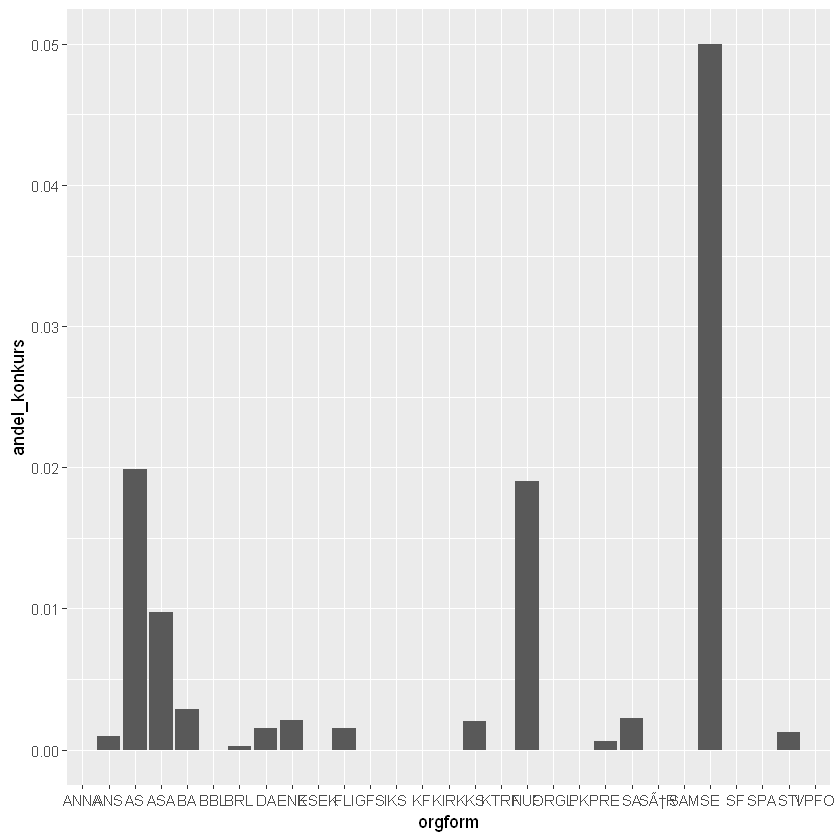

In [12]:
#Plotting with relative shares.
plot_1f = 
  ggplot(table_1d, aes(x=orgform))+
  geom_col(aes(y = andel_konkurs))
plot_1f

In [13]:
#Now, in plot f, we can actually see that the organizational form with the highest share of bankruptcies is SE.
#But from table 1d we read that it only has one bankruptcy, so this must be considered a random, not trustworthy statistic.
#Apart from that, AS is still highest, with NUF behind and all others quite far below. 

#Making a subset data set consisting only of AS and ASA org forms, because they are two of the most common and interesting ones.
#Especially ASA is of course by definition the only publicly traded form, and so it is relevant for investors to predict bankruptcy. 
#Of course, it can also be useful for other interests, such as banks wishing to evaluate risk of approving loans to businesses. 
data2 = subset(data, orgform=='AS' | orgform == 'ASA')

#Making a subset of the previous subset with only Norwegian companies; since none were excluded all were Norwegian from the start. 
data3 = subset(data2, landkode == 'NO')

In [14]:
#Making some new variables used to make Altmans Z-score formula for predicting bankrupty.
data3$x1 = (data3$Sum_omloepsmidler-data3$Sum_kortsiktig_gjeld)/data3$SUM_EIENDELER
data3$x2 = data3$Sum_opptjent_egenkapital/data3$SUM_EIENDELER
data3$x3 = data3$Driftsresultat/data3$SUM_EIENDELER
data3$x4 = data3$Sum_egenkapital/data3$Sum_gjeld
data3$x5 = data3$Sum_inntekter/data3$SUM_EIENDELER

In [18]:
#Making new variables based on the Norwegian central bank SEBRA model.
data3$v1 = (data3$Ordinaert_resultat_foer_skattekostnad-data3$Nedskrivning_av_varige_driftsmidler_og_immaterielle_eiendeler- data3$Nedskrivning_av_finansielle_eiendeler-data3$Avskrivning_paa_varige_driftsmidler_og_immaterielle_eiendeler)/data3$Sum_gjeld
data3$v2 = data3$Sum_egenkapital/data3$SUM_EIENDELER
data3$v3 = ifelse(data3$Sum_innskutt_egenkapital<data3$Sum_egenkapital,1,0)
data3$v4 = (data3$`Sum_bankinnskudd,_kontanter_og_lignende`-data3$Sum_kortsiktig_gjeld)/data3$Sum_inntekter
data3$v5 = data3$Leverandoergjeld/data3$SUM_EIENDELER
data3$v6 = data3$Skyldige_offentlige_avgifter/data3$SUM_EIENDELER
data3$alder_i_år = data3$alder_i_dager/365 #litt feil pga skuddår men la gå.
data3$a1 = ifelse(data3$alder_i_år>=1, 1,0)
data3$a2 = ifelse(data3$alder_i_år>=2, 1,0)
data3$a3 = ifelse(data3$alder_i_år>=3, 1,0)
data3$a4 = ifelse(data3$alder_i_år>=4, 1,0)
data3$a5 = ifelse(data3$alder_i_år>=5, 1,0)
data3$a6 = ifelse(data3$alder_i_år>=6, 1,0)
data3$a7 = ifelse(data3$alder_i_år>=7, 1,0)
data3$a8 = ifelse(data3$alder_i_år>=8, 1,0)

In [20]:
#Removing firms with less than NOK 500 000 in assets,
#and removing business codes not used in the norwegian bank model.
data_sebra = subset(data3, SUM_EIENDELER>= 500000)
data_sebra = data_sebra[!(naeringskode=="O"|naeringskode=="T"|naeringskode=="U"|naeringskode=="K"|naeringskode=="E"|naeringskode=="D"|naeringskode==0|naeringskode=="MISSING"),]


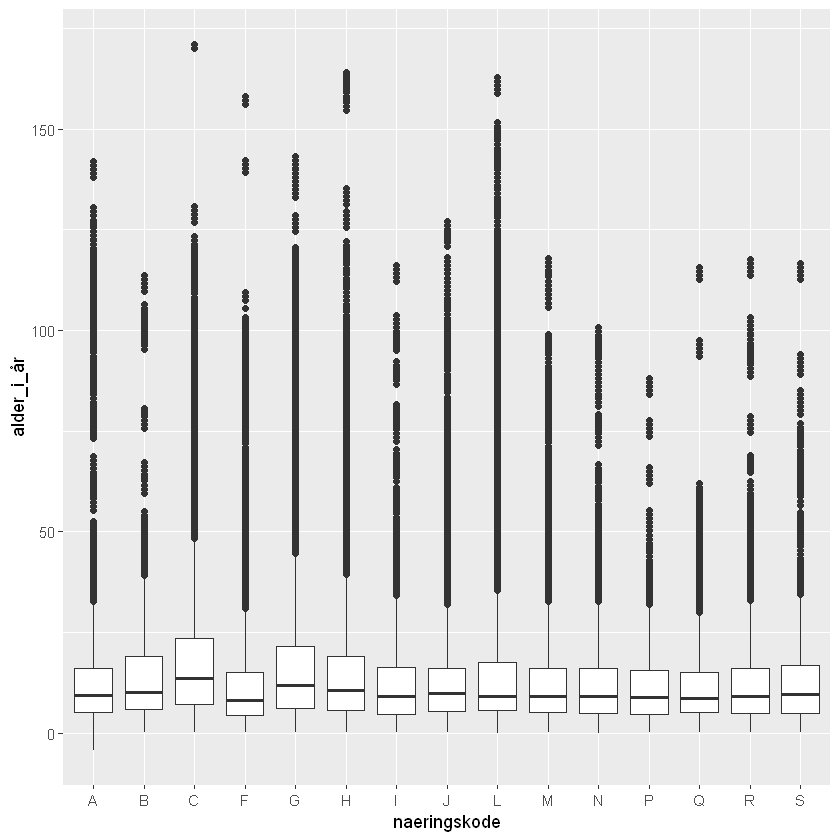

In [21]:
#Plotting age per business code to see what kinds of businesses last the longest.
plot_2d = ggplot(data_sebra, aes(x=naeringskode, y=alder_i_år)) + 
  geom_boxplot()
plot_2d 

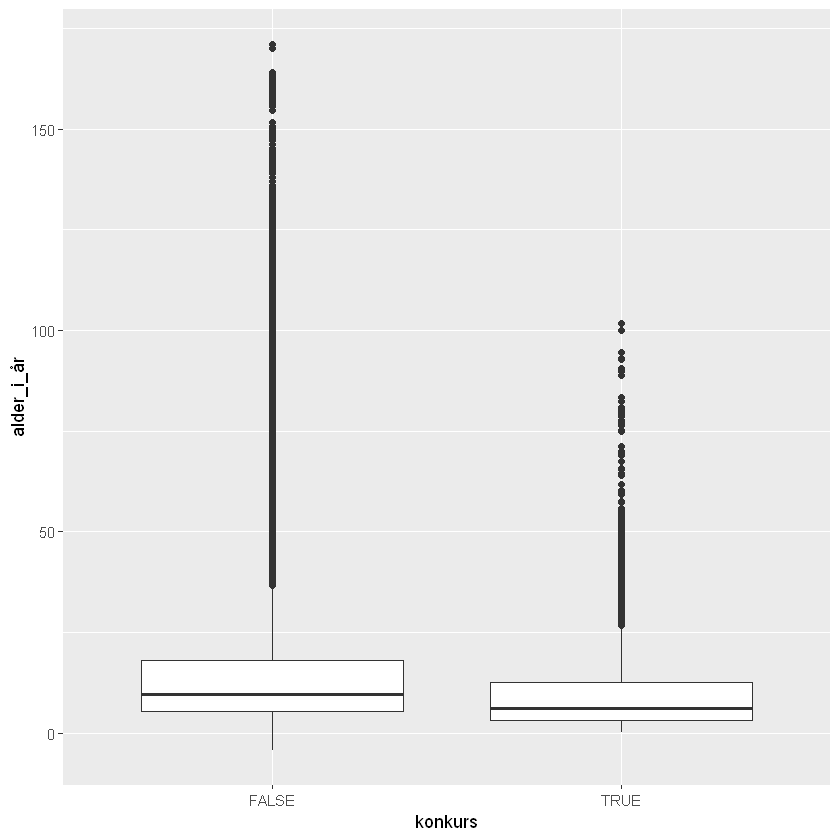

In [22]:
#Plotting average age of bankrupt and not bankrupt businesses. 
plot_2d2 = ggplot(data_sebra, aes(x=konkurs, y=alder_i_år)) + 
  geom_boxplot()
plot_2d2   

In [23]:
#Since many of the variables created are relative, 
#We need to change some values who end up as infinity to 0.
data_sebra[which(is.infinite(data_sebra$x1)|is.na(data_sebra$x1)),'x1'] = 0
data_sebra[which(is.infinite(data_sebra$x2)|is.na(data_sebra$x2)),'x2'] = 0
data_sebra[which(is.infinite(data_sebra$x3)|is.na(data_sebra$x3)),'x3'] = 0
data_sebra[which(is.infinite(data_sebra$x4)|is.na(data_sebra$x4)),'x4'] = 0
data_sebra[which(is.infinite(data_sebra$x5)|is.na(data_sebra$x5)),'x5'] = 0
data_sebra[which(is.infinite(data_sebra$v1)|is.na(data_sebra$v1)),'v1'] = 0
data_sebra[which(is.infinite(data_sebra$v2)|is.na(data_sebra$v2)),'v2'] = 0
data_sebra[which(is.infinite(data_sebra$v4)|is.na(data_sebra$v4)),'v4'] = 0
data_sebra[which(is.infinite(data_sebra$v5)|is.na(data_sebra$v5)),'v5'] = 0
data_sebra[which(is.infinite(data_sebra$v6)|is.na(data_sebra$v6)),'v6'] = 0

In [24]:
install.packages('ISLR')
library(ISLR)

#Checking the newest year of accounts.
max(data_sebra$regnaar)


package 'ISLR' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\haava\AppData\Local\Temp\RtmpY9vnOY\downloaded_packages


Warning message:
"package 'ISLR' was built under R version 3.6.3"

[1] 2015

In [25]:
#Making test set with the newest year, 2015, and using the rest as
#training data.
test = data_sebra[data_sebra$regnaar>=2015]
train = data_sebra[data_sebra$regnaar<2015]

In [26]:

#This forces R to not give output numbers in scientific notation
#Remove it if you want to.
options(scipen=999)

In [27]:
#Changing the factor values to numeric, to be able to perform 
#regression and other analysis. 
train$konkurs = as.numeric(train$konkurs)
test$konkurs = as.numeric(test$konkurs)

In [28]:
#Here we are performing a linear regression with the Altman Z-score variables as predictors
model_lm_altmann = lm(konkurs~x1+x2+x3+x4+x5,data = train)

#summary stats of the model

summary(model_lm_altmann)


Call:
lm(formula = konkurs ~ x1 + x2 + x3 + x4 + x5, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.15491 -0.01206 -0.00831 -0.00715  1.09560 

Coefficients:
                    Estimate       Std. Error t value             Pr(>|t|)    
(Intercept)  0.0075728343231  0.0001561917894  48.484 < 0.0000000000000002 ***
x1          -0.0026927933728  0.0001417171939 -19.001 < 0.0000000000000002 ***
x2          -0.0000888752158  0.0000279854916  -3.176              0.00149 ** 
x3          -0.0089547585487  0.0003165595952 -28.288 < 0.0000000000000002 ***
x4          -0.0000000002395  0.0000000014811  -0.162              0.87152    
x5           0.0028310207316  0.0000626197008  45.210 < 0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1013 on 622644 degrees of freedom
Multiple R-squared:  0.005507,	Adjusted R-squared:  0.005499 
F-statistic: 689.6 on 5 and 622644 DF,  p-value: < 0.0000000000000002

In [29]:
#prediction on the test set with the fitted model from above
test$probs_konkurs_lm = predict(model_lm_altmann,test)
test$bin_konkurs_lm = ifelse(test$probs_konkurs_lm>=0.5,1,0)

#Confusion matrix too observe how many true positives and so on
table(test$konkurs,test$bin_konkurs_lm)


   
         0      1
  0 162843      5
  1   4709      0

In [30]:
#Clearing up some memory space, our weak computer struggles(Is there a convention for doing this?)
data2=0
data=0
data3=0

#Making a logistic regression model, with the same procedure after fitting.
model_lr_altman = glm(konkurs~x1+x2+x3+x4+x5,data=train, family=binomial)
summary(model_lr_altman)


test$probs_konkurs_lr = predict(model_lr_altman,test,type="response")
test$bin_konkurs_lr = ifelse(test$probs_konkurs_lr>=0.5,1,0)
table(test$konkurs,test$bin_konkurs_lr)


Call:
glm(formula = konkurs ~ x1 + x2 + x3 + x4 + x5, family = binomial, 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.0832  -0.1470  -0.1367  -0.1340   3.4363  

Coefficients:
                  Estimate     Std. Error  z value             Pr(>|z|)    
(Intercept) -4.70763376380  0.01440498711 -326.806 < 0.0000000000000002 ***
x1          -0.04543548647  0.00812626908   -5.591         0.0000000226 ***
x2          -0.00118054663  0.00064641321   -1.826               0.0678 .  
x3          -0.17830368337  0.01772712422  -10.058 < 0.0000000000000002 ***
x4          -0.00000006011  0.00000021904   -0.274               0.7838    
x5           0.10259207003  0.00363416616   28.230 < 0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 72195  on 622649  degrees of freedom
Residual deviance: 71168  on 622644  degrees of freedom
AIC: 711

   
         0      1
  0 162828     20
  1   4707      2

In [31]:
#Now we are training a logistic model to predict using the SEBRA based model instead of the Altman Z. 
model_lr_sebra = glm(konkurs~v1+v2+v3+v4+v5+v6+a1+a2+a3+a4+a5+a6+a7+a8,data=train, family=binomial)
summary(model_lr_sebra)
test$probs_konkurs_lr_s = predict(model_lr_sebra,test,type="response")
test$bin_konkurs_lr_s = ifelse(test$probs_konkurs_lr_s>=0.5,1,0)
table(test$konkurs,test$bin_konkurs_lr_s)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Call:
glm(formula = konkurs ~ v1 + v2 + v3 + v4 + v5 + v6 + a1 + a2 + 
    a3 + a4 + a5 + a6 + a7 + a8, family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-8.4904  -0.1618  -0.1034  -0.0877   3.3737  

Coefficients:
                  Estimate     Std. Error z value             Pr(>|z|)    
(Intercept) -3.63476530769  0.08145254062 -44.624 < 0.0000000000000002 ***
v1           0.00000002439  0.00000071963   0.034              0.97296    
v2          -0.02145080725  0.00332821145  -6.445       0.000000000115 ***
v3          -1.29472165857  0.02657940309 -48.711 < 0.0000000000000002 ***
v4           0.00000064265  0.00000171535   0.375              0.70792    
v5           0.50844676316  0.02612430216  19.463 < 0.0000000000000002 ***
v6           2.78764354807  0.07659042632  36.397 < 0.0000000000000002 ***
a1           0.02888059326  0.08985135589   0.321              0.74789    
a2           0.08795435542  0.05360435395   1.641         

   
         0      1
  0 162818     30
  1   4701      8

In [33]:
install.packages('pROC')
library(pROC)
#Making ROC-plot with the altman model and SEBRA model, showing prediction accuracies.
roc(test$konkurs, test$probs_konkurs_lr)



  There is a binary version available but the source version is later:
     binary   source needs_compilation
pROC 1.16.2 1.17.0.1              TRUE

  Binaries will be installed
package 'pROC' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\haava\AppData\Local\Temp\RtmpY9vnOY\downloaded_packages


Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var

Setting levels: control = 0, case = 1
Setting direction: controls < cases



Call:
roc.default(response = test$konkurs, predictor = test$probs_konkurs_lr)

Data: test$probs_konkurs_lr in 162848 controls (test$konkurs 0) < 4709 cases (test$konkurs 1).
Area under the curve: 0.7455

In [34]:
#The SEBRA model is a bit better
roc(test$konkurs, test$probs_konkurs_lr_s)

Setting levels: control = 0, case = 1
Setting direction: controls < cases



Call:
roc.default(response = test$konkurs, predictor = test$probs_konkurs_lr_s)

Data: test$probs_konkurs_lr_s in 162848 controls (test$konkurs 0) < 4709 cases (test$konkurs 1).
Area under the curve: 0.7554

In [36]:

library(class)
library(lattice)
library(ggplot2)
library(caret)
#Training a model using KNN with the altman variables. Using only one year as training data, because KNN requires a lot of computing power. 
train_2014 = train[train$regnaar == 2014]
train_x = cbind(train_2014$x1,train_2014$x2,train_2014$x3,train_2014$x4,train_2014$x5)
test_x = cbind(test$x1,test$x2,test$x3,test$x4,test$x5)
test$pred_knn = knn(train_x, test_x,train_2014$konkurs, k=2)
table(test$konkurs,test$pred_knn)


   
         0      1
  0 161454   1394
  1   4572    137

In [38]:
# Using k-fold crossvalidation and finding the average AUC across all folds.
#First with altman Z, then with SEBRA variables in the next box. 
#Fitting a logistic model.
sum_auc = 0
data_sebra$konkurs=as.numeric(data_sebra$konkurs)
for (year in 2013:2015){
  train = data_sebra[data_sebra$regnaar<year,]
  train = data_sebra[data_sebra$regnaar>=year-2,]
  test = data_sebra[data_sebra$regnaar == year,]
  model_lr_kfold = glm(konkurs~x1+x2+x3+x4+x5,data = train, family = binomial)
  test$probs_konkurs_lr_kfold = predict(model_lr_kfold,test, type = "response")
  roc_ting = roc(test$konkurs, test$probs_konkurs_lr_kfold)
  sum_auc = sum_auc+roc_ting$auc
}
gjennom = sum_auc/3


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Setting levels: control = 0, case = 1
Setting direction: controls < cases


In [41]:
sum_auc_s = 0
data_sebra$konkurs=as.numeric(data_sebra$konkurs)
for (year in 2013:2015){
  train = data_sebra[data_sebra$regnaar<year,]
  train = data_sebra[data_sebra$regnaar>=year-2,]
  test = data_sebra[data_sebra$regnaar == year,]
  model_lrs_kfold = glm(konkurs~v1+v2+v3+v4+v5+v6+a1+a2+a3+a4+a5+a6+a7+a8,data = train, family = binomial)
  test$probs_konkurs_lrs_kfold = predict(model_lrs_kfold,test, type = "response")
  roc_ting = roc(test$konkurs, test$probs_konkurs_lrs_kfold)
  sum_auc_s = sum_auc_s+roc_ting$auc
}
gjennom_s = sum_auc_s/3

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Setting levels: control = 0, case = 1
Setting direction: controls < cases


In [42]:
print(gjennom)
print(gjennom_s)

[1] 0.7319838
[1] 0.7745542
